In [ ]:
from ACNet_v1 import ACNet
from ACNet_v1 import ReplayMemory
import FireFightingEnv as FFEnv
import torch
import torch.optim as optim
import random
import math
import time
from collections import namedtuple, deque
from itertools import count
import torch.nn as nn

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

AGT_COUNT = 3
GRID_SIZE = 11

env = FFEnv.FFEnv(AGT_COUNT)
# Get number of actions from gym action space
n_actions = 10
# Get the number of state observations
state = env.reset()
# n_observations = state
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

policy_net = ACNet(n_actions, GRID_SIZE).to(device)
target_net = ACNet(n_actions, GRID_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

In [ ]:
def select_action(input, water_res):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # print(type(policy_net(input, water_res).max(1)[1].view(1, 1)))
            return policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1)

    else:
        return torch.tensor([[random.randint(0, 9)]], device=device, dtype=torch.long)


episode_durations = []

            


In [ ]:
Transition = namedtuple('Transition',
                        ('state_map', 'state_water', 'action', 'next_state_map', 'next_state_water', 'reward'))

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state_map)), device=device, dtype=torch.bool)
    non_final_next_states_map = torch.stack([s for s in batch.next_state_map
                                                if s is not None], dim=0)
    non_final_next_states_water = torch.cat([s for s in batch.next_state_water
                                                if s is not None])
    state_map_batch = torch.stack(batch.state_map, dim=0)
    state_water_batch = torch.cat(batch.state_water)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_map_batch, state_water_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states_map, non_final_next_states_water).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    


[[2, 1], [2, 1], [2, 1]]
[0. 0. 0.]


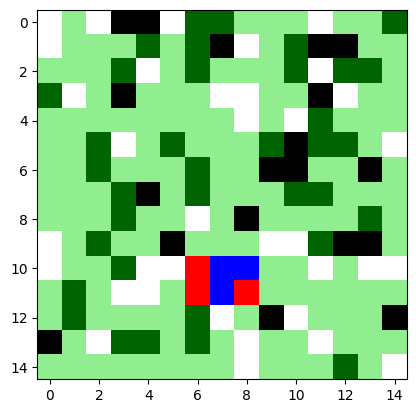

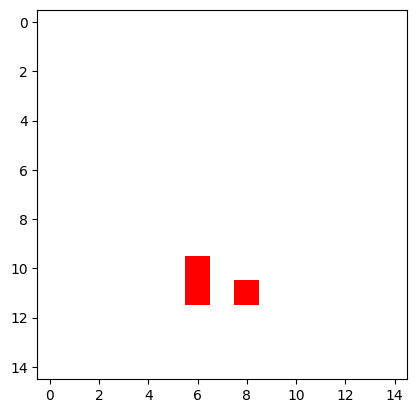

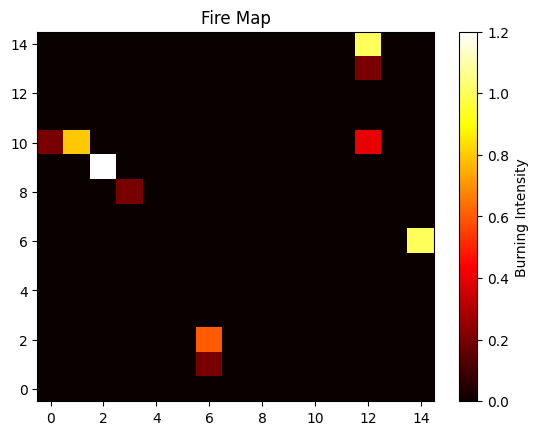

[[4, 1], [4, 1], [0, 1]]
[ 0.    0.   -0.05]


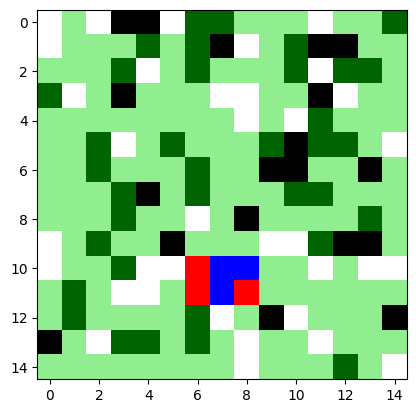

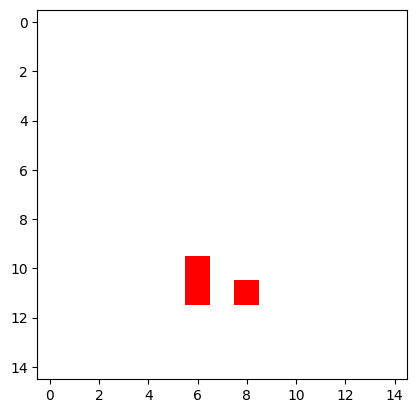

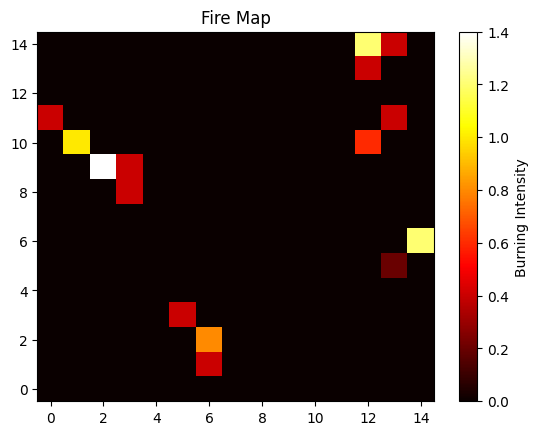

[[0, 0], [2, 1], [4, 0]]
[0.05 0.   0.05]


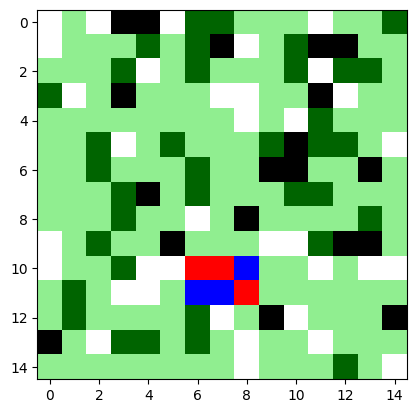

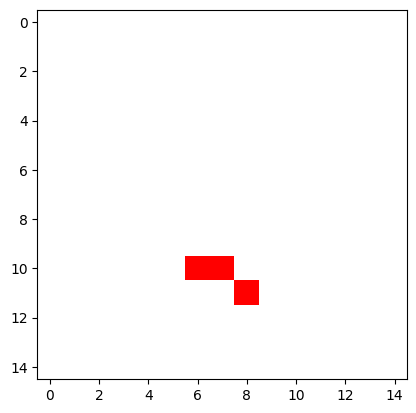

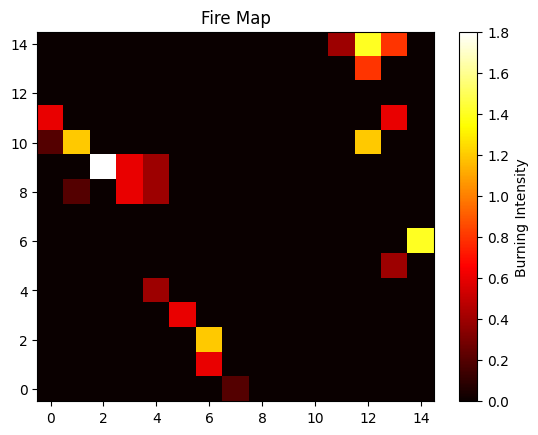

KeyboardInterrupt: 

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

DEBUG = True


for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    states= env.reset()
    # states = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    # print(states)
    for t in count():
        actions = []
        action_is = []
        water_res_states = []
        input_states = []
        for state in states:
            # state = torch.tensor(state, dtype=torch.float32, device=device)
            input = state[0]
            water_res = state[1]
            water_res = torch.tensor([[water_res]], device=device).float()
            input = torch.from_numpy(input).float().to(device)
            #input = torch.tensor([[input]], device=device).float()
            action_i = select_action(input, water_res)
            action_int = action_i.item()
            action = [action_int % 5, int(action_int / 5)]
            actions.append(action) # For env update
            
            # For network update
            water_res_states.append(water_res)
            input_states.append(input)
            action_is.append(action_i)
            
        observations, rewards, terminated = env.step(actions)
        print(actions)
        print(rewards)
        rewards_tensors = []
        for i, reward in enumerate(rewards):
            # print(type(torch.tensor([reward], device=device)))
            rewards_tensors.append(torch.tensor([reward], device=device))
        
        done = terminated

        if terminated:
            next_states = None
        else:
            next_states = observations
            next_input_states = []
            next_water_states = []
            for state in next_states:
                # state = torch.tensor(state, dtype=torch.float32, device=device)
                input = state[0]
                water_res = state[1]
                water_res = torch.tensor([[water_res]]).float()
                input = torch.from_numpy(input).float().to(device)
                
                # For network update
                next_water_states.append(water_res)
                next_input_states.append(input)
                # next_states = torch.tensor(observations, dtype=torch.float32, device=device)
            # Store the transition in memory
            for i in range(AGT_COUNT):
                memory.push(input_states[i], water_res_states[i], action_is[i], next_input_states[i], next_water_states[i], rewards_tensors[i])

            # Move to the next state
            states = next_states

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if DEBUG:
                env.mapEnv.plotAll()
                env.mapEnv.plotAgent()
                env.mapEnv.plotFireMap()
                time.sleep(10) # For Debugging

            if done or t > 100:
                episode_durations.append(t + 1)
                break
